In [131]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.model_selection import KFold
import lightgbm as lgb
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

train_gps_path = 'train_data_clean.csv'
train_data_path = 'train0711.csv'
test_data_path = 'testB.csv'
order_data_path = 'loadingOrderEvent.csv'
port_data_path = 'port.csv'

# 取前1000000行
debug = True
NDATA = 50000000
skip = 4

MMSI_map = {}

def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            print("**************************")
            print("columns: ", col)
            print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # # Integer does not support NA, therefore Na needs to be filled
            # if not np.isfinite(props[col]).all():
            #     NAlist.append(col)
            #     props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            print("dtype after", props[col].dtype)
            print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props#, NAlist

# 处理数据，将时间转换为datatime格式
def get_data(data, mode='train'):
    
    assert mode == 'train' or mode == 'test' or mode == 'port'
    
    if mode == 'train' or mode == 'test':
        if mode == 'test':
            data['temp_timestamp'] = data['timestamp']
            data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format = True)
        data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
        data['longitude'] = data['longitude'].astype(float)
        data['loadingOrder'] = data['loadingOrder'].astype(str)
        data['latitude'] = data['latitude'].astype(float)
        data['speed'] = data['speed'].astype(float)
    elif mode == 'port':
        # data['LONGITUDE'] = data['LONGITUDE'].astype(float)
        # data['LATITUDE'] = data['LATITUDE'].astype(float)
        data['LONGITUDE'] = pd.to_numeric(data['LONGITUDE'])
        data['LATITUDE'] =  pd.to_numeric(data['LATITUDE'])
        data['LONGITUDE'] = data['LONGITUDE'].astype(float)
        data['LATITUDE'] = data['LATITUDE'].astype(float)
    return data
import gc 
gc.collect()

0

In [3]:
if __name__ == '__main__':
    names = ['loadingOrder', 'timestamp', 'longitude', 'latitude', 'vesselMMSI', 'speed', 'direction', 'TRANSPORT_TRACE']
    chunksize = True
    if chunksize:
        #train_flux = pd.read_csv(train_data_path, usecols = [0, 2, 3, 4, 5, 6, 7, 12], names = names, chunksize = 10000000)
        train_flux = pd.read_csv(train_gps_path, chunksize = 10000000)
        train_data = pd.DataFrame(columns = names)
        for data in tqdm(train_flux):
            temp_data = reduce_mem_usage(data)
            train_data = train_data.append(temp_data)
    else:
        train_data = pd.read_csv(train_gps_path, nrows = 100000)
        train_data = reduce_mem_usage(train_data)

    #train_data.drop_duplicates(subset = ['loadingOrder', 'timestamp', 'longitude', 'latitude'], keep = 'first', inplace = True)
    print(train_data.shape[0])
    
    # train_data = train_data.copy()
    # train_data.to_csv('train_clean.csv', index = False)
    
    # 删除没有trace信息的数据
    #train_data = train_data[~train_data['TRANSPORT_TRACE'].isin([np.nan])]
    #print(train_data.shape[0])
    #train_data.to_csv('train_trace_1.csv', index = False)
    
    # 删除trace长度小于2的
    #train_data = train_data[train_data['TRANSPORT_TRACE'].str.split('-').str.len() >= 2]
    #print(train_data.shape[0])
    #train_data.to_csv('train_trace_2.csv', index = False)
    
    # 删除重复的GPS数据（相同订单号，相同时间和相同经纬度）

#train_data.sort_values(['loadingOrder', 'timestamp'], inplace = True)
#train_data.to_csv('clean_sort_data.csv', index = False)
#train_data = train_data.iloc[1:, :]
train_data = get_data(train_data, mode = 'train')
#train_2_port = train_data[train_data['TRANSPORT_TRACE'].str.split('-').str.len() == 2]
#train_3_port = train_data[train_data['TRANSPORT_TRACE'].str.split('-').str.len() > 2]
train_data

0it [00:00, ?it/s]

Memory usage of the dataframe is : 610.3516845703125 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.006591796875  MB
This is  64.06250718749857 % of the initial size


1it [00:17, 17.96s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


2it [00:35, 17.84s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


3it [00:55, 18.37s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


4it [01:17, 19.42s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


5it [01:41, 20.92s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


6it [02:09, 22.98s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


7it [02:39, 25.21s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


8it [03:13, 27.66s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


9it [03:49, 30.26s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


10it [04:28, 32.83s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


11it [05:08, 35.13s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


12it [05:52, 37.70s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


13it [06:44, 42.10s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


14it [07:34, 44.30s/it]

Memory usage of the dataframe is : 610.3516883850098 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  391.00659561157227  MB
This is  64.06250741210785 % of the initial size


15it [08:25, 46.27s/it]

Memory usage of the dataframe is : 118.93652725219727 MB
**************************
columns:  longitude
dtype before float64
dtype after float16
********************************
**************************
columns:  latitude
dtype before float64
dtype after float16
********************************
**************************
columns:  speed
dtype before int64
dtype after uint8
********************************
**************************
columns:  direction
dtype before int64
dtype after int32
********************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  76.19375801086426  MB
This is  64.06253803703238 % of the initial size


16it [09:07, 34.21s/it]


119568756


,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE
5738029,AA191175561416,2019-01-28 16:12:59+00:00,114.25,22.578125,Y7540547327,0.0,12670,CNYTN-MXZLO
5739749,AA191175561416,2019-01-28 16:22:38+00:00,114.25,22.578125,Y7540547327,0.0,14790,CNYTN-MXZLO
5740997,AA191175561416,2019-01-28 16:30:55+00:00,114.25,22.578125,Y7540547327,0.0,21510,CNYTN-MXZLO
5741931,AA191175561416,2019-01-28 16:37:35+00:00,114.25,22.578125,Y7540547327,0.0,19900,CNYTN-MXZLO
5743324,AA191175561416,2019-01-28 16:45:56+00:00,114.25,22.578125,Y7540547327,0.0,21360,CNYTN-MXZLO
...,...,...,...,...,...,...,...,...
48755414,ZZ992682575994,2019-03-11 16:00:39+00:00,101.25,2.796875,V8626322848,2.0,35420,CNSHK-MYPKE
48756216,ZZ992682575994,2019-03-11 16:01:10+00:00,101.25,2.796875,V8626322848,2.0,35320,CNSHK-MYPKE
48757112,ZZ992682575994,2019-03-11 16:01:50+00:00,101.25,2.796875,V8626322848,2.0,34810,CNSHK-MYPKE
48758282,ZZ992682575994,2019-03-11 16:02:30+00:00,101.25,2.796875,V8626322848,2.0,34710,CNSHK-MYPKE


In [4]:
#train_data['diff_time'] = train_data.groupby('loadingOrder')['timestamp'].diff(1).dt.total_seconds() / 60
#train_data['diff_lat'] = train_data.groupby('loadingOrder')['latitude'].diff(1)
#train_data['diff_lon'] = train_data.groupby('loadingOrder')['longitude'].diff(1)
#train_data.fillna(0, inplace = True)
#train_data.reset_index(inplace = True, drop = True)
train_data

,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,diff_time,diff_lat,diff_lon
0,AA191175561416,2019-01-28 16:12:59+00:00,114.25,22.578125,Y7540547327,0.0,12670,CNYTN-MXZLO,0.000000,0.0,0.0
1,AA191175561416,2019-01-28 16:22:38+00:00,114.25,22.578125,Y7540547327,0.0,14790,CNYTN-MXZLO,9.650000,0.0,0.0
2,AA191175561416,2019-01-28 16:30:55+00:00,114.25,22.578125,Y7540547327,0.0,21510,CNYTN-MXZLO,8.283333,0.0,0.0
3,AA191175561416,2019-01-28 16:37:35+00:00,114.25,22.578125,Y7540547327,0.0,19900,CNYTN-MXZLO,6.666667,0.0,0.0
4,AA191175561416,2019-01-28 16:45:56+00:00,114.25,22.578125,Y7540547327,0.0,21360,CNYTN-MXZLO,8.350000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
119568751,ZZ992682575994,2019-03-11 16:00:39+00:00,101.25,2.796875,V8626322848,2.0,35420,CNSHK-MYPKE,0.466667,0.0,0.0
119568752,ZZ992682575994,2019-03-11 16:01:10+00:00,101.25,2.796875,V8626322848,2.0,35320,CNSHK-MYPKE,0.516667,0.0,0.0
119568753,ZZ992682575994,2019-03-11 16:01:50+00:00,101.25,2.796875,V8626322848,2.0,34810,CNSHK-MYPKE,0.666667,0.0,0.0
119568754,ZZ992682575994,2019-03-11 16:02:30+00:00,101.25,2.796875,V8626322848,2.0,34710,CNSHK-MYPKE,0.666667,0.0,0.0


In [132]:
# 求出测试数据中所有的港口信息
# 读取测试数据
test_data = pd.read_csv(test_data_path)
test_data = get_data(test_data, mode = 'test')
# 获取测试数据的港口信息
test_trace = pd.DataFrame()
test_trace[['loadingOrder', 'TRANSPORT_TRACE', 'longitude', 'latitude']] = test_data[['loadingOrder', 'TRANSPORT_TRACE', 'longitude', 'latitude']]
test_trace.drop_duplicates(subset = ['loadingOrder', 'TRANSPORT_TRACE'], keep = 'first', inplace = True)
test_trace.reset_index(inplace = True)
del test_trace['index']
test_trace

,loadingOrder,TRANSPORT_TRACE,longitude,latitude
0,NJ169522947117,CNSHK-SGSIN,110.760670,12.794997
1,SX540070026140,CNSHK-MYTPP,110.662020,12.281523
2,ZV919459607351,CNSHK-BHBAH,66.776400,17.426293
3,AE378244933121,CNSHK-EGPSD,71.262752,7.878960
4,FQ684650477699,CNYTN-BRSSZ,105.383015,3.054528
...,...,...,...,...
234,AM438554857021,CNYTN-PAONX,114.336137,22.557467
235,JY538030984696,CNYTN-PAONX,115.326340,22.234330
236,HM477496559738,CNSHK-KRINC,121.177048,26.465133
237,XH403100738321,CNSHK-SGSIN-AEJEA,113.898995,22.385950


In [5]:
# 删除中间跳跃较大的数据
del_order = []

del_order3 = np.array(train_data[train_data['speed'] >= 65]['loadingOrder'])
del_order3 = set(del_order3)
del_order3 = list(del_order3)
print(len(del_order3))


del_order2 = np.array(train_data[abs(train_data['diff_lon']) + abs(train_data['diff_lat']) >= 35]['loadingOrder'])
del_order2 = set(del_order2)
del_order2 = list(del_order2)
print(len(del_order2))
    
del_order1 = np.array(train_data[abs(train_data['diff_lon']) > 180]['loadingOrder'])
del_order1 = set(del_order1)
del_order1 = list(del_order1)
print(len(del_order1))

for i in range(len(del_order2)):
    if del_order2[i] not in del_order1:
        del_order.append(del_order2[i])

for i in range(len(del_order3)):
    del_order.append(del_order3[i])
#train_back = train_data[train_data['diff_time'] >= 14400]
#for i in train_back.index:
#    del_order.append(train_back.loc[i, 'loadingOrder'])
del_order = set(del_order)
del_order = list(del_order)
len(del_order)

1724
3004
2172


2419

In [6]:
train_data = train_data[~train_data['loadingOrder'].isin(del_order)]
train_data.reset_index(inplace = True, drop = True)
train_data

,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,diff_time,diff_lat,diff_lon
0,AA191175561416,2019-01-28 16:12:59+00:00,114.25,22.578125,Y7540547327,0.0,12670,CNYTN-MXZLO,0.000000,0.0,0.0
1,AA191175561416,2019-01-28 16:22:38+00:00,114.25,22.578125,Y7540547327,0.0,14790,CNYTN-MXZLO,9.650000,0.0,0.0
2,AA191175561416,2019-01-28 16:30:55+00:00,114.25,22.578125,Y7540547327,0.0,21510,CNYTN-MXZLO,8.283333,0.0,0.0
3,AA191175561416,2019-01-28 16:37:35+00:00,114.25,22.578125,Y7540547327,0.0,19900,CNYTN-MXZLO,6.666667,0.0,0.0
4,AA191175561416,2019-01-28 16:45:56+00:00,114.25,22.578125,Y7540547327,0.0,21360,CNYTN-MXZLO,8.350000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
101670888,ZZ992682575994,2019-03-11 16:00:39+00:00,101.25,2.796875,V8626322848,2.0,35420,CNSHK-MYPKE,0.466667,0.0,0.0
101670889,ZZ992682575994,2019-03-11 16:01:10+00:00,101.25,2.796875,V8626322848,2.0,35320,CNSHK-MYPKE,0.516667,0.0,0.0
101670890,ZZ992682575994,2019-03-11 16:01:50+00:00,101.25,2.796875,V8626322848,2.0,34810,CNSHK-MYPKE,0.666667,0.0,0.0
101670891,ZZ992682575994,2019-03-11 16:02:30+00:00,101.25,2.796875,V8626322848,2.0,34710,CNSHK-MYPKE,0.666667,0.0,0.0


In [168]:
test_label = np.zeros(len(test_trace))
from geopy.distance import distance
indexes = []

In [134]:
np.save('8_7_A_index.npy', indexes)

In [ ]:
# 修改，使用groupby('TRANSPORT_TRACE')
gc.collect()
def matching(test_trace, port_data):
    #train_data.sort_values(['loadingOrder', 'timestamp'], inplace = True)
    train_group_1 = train_data.groupby('TRANSPORT_TRACE')
    port_group = port_data.groupby('TRANS_NODE_NAME')
    print('start matching!!!')
    # 首先匹配长度为2的
    for i in test_trace.index:
        trace = test_trace.loc[i, 'TRANSPORT_TRACE'].split('-')
        if test_label[i] == 0:
            print(i)
            cur_order = []
            cur_label = []
            seconds = []
            dis_arr = []
            index_arr = []
            true_lat = port_group.get_group(trace[0]).iloc[0, 2]
            true_lon = port_group.get_group(trace[0]).iloc[0, 1]
            start_lat = test_trace.loc[i, 'latitude']
            start_lon = test_trace.loc[i, 'longitude']
            end_lat = port_group.get_group(trace[-1]).iloc[0, 2]
            end_lon = port_group.get_group(trace[-1]).iloc[0, 1]
            print(trace, start_lat, start_lon, end_lat, end_lon)
            if trace == ['HUNGARY', 'HON']:
                trace = ['HUNGARY', 'HONGKONG']
            if trace == ['LTKLJ', 'DEHAM', 'HKHKG']:
                trace = ['LTKLJ', 'DEHAM', 'HONG KONG_HONG KONG']
            if trace == ['CNSHK', 'SGSIN', 'MTMLA', 'DZALG']:
                trace = ['CNYTN', 'SGSIN', 'MTMLA', 'DZALG']
            for name1, group1 in train_group_1:
                # group.drop_duplicates(subset = ['longitude', 'latitude'], keep = 'first', inplace = True)
                cur_trace = str(name1).split('-')
                # 判断是否含有终点
                if trace == cur_trace:
                    cur_order.append(name1)
                    train_group_2 = group1.groupby('loadingOrder')
                    for name, group in train_group_2:
                        #index.append(list(group_2.index)[0])
                        start_time = group.loc[group.index[0], 'timestamp']
                        start_index = group.index[0]
                        judge = False
                        for j in group.index:
                            # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                            if abs(group.loc[j, 'longitude'] - start_lon) <= 0.15 and \
                                abs(group.loc[j, 'latitude'] - start_lat) <= 0.15 and \
                                not judge:
                                start_time = group.loc[j, 'timestamp']
                                start_index = j
                                judge = True

                        if judge:
                            tmp = []
                            for j in group.index[::-1]:
                                if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                    abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                    group.loc[j, 'speed'] > 0:
                                    tmp.append(name)
                                    tmp.append(start_index)
                                    tmp.append(j)
                                    tmp.append(test_trace.loc[i, 'loadingOrder'])
                                    index_arr.append(tmp)
                                    time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                    cur_label.append(time_gap)
                                    break
            if len(cur_label) < 5:
                print('中间港到达')
                for name1, group1 in train_group_1:
                    # group.drop_duplicates(subset = ['longitude', 'latitude'], keep = 'first', inplace = True)
                    cur_trace = str(name1).split('-')
                    if trace[0] in cur_trace and trace[1] in cur_trace and \
                        cur_trace.index(trace[0]) < cur_trace.index(trace[1]):
                        cur_order.append(name1)
                        train_group_2 = group1.groupby('loadingOrder')
                        for name, group in train_group_2:
                            #index.append(list(group_2.index)[0])
                            start_time = group.loc[group.index[0], 'timestamp']
                            start_index = group.index[0]
                            judge = False
                            for j in group.index:
                                # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                                if abs(group.loc[j, 'longitude'] - start_lon) <= 0.15 and \
                                    abs(group.loc[j, 'latitude'] - start_lat) <= 0.15 and \
                                    not judge:
                                    start_time = group.loc[j, 'timestamp']
                                    start_index = j
                                    judge = True
                            if judge:
                                tmp = []
                                for j in group.index[::-1]:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break
                                tmp = []
                                for j in group.index:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break 
            if len(cur_label) < 5:
                print('匹配无路由的数据')
                for name1, group1 in train_group_1:
                    if name in cur_order:
                        continue
                    if len(cur_label) >= 10:
                        break
                    cur_trace = str(name1).split('-')
                    if trace[-1] in cur_trace or len(cur_trace) < 2:
                        train_group_2 = group1.groupby('loadingOrder')
                        for name, group in train_group_2:
                            start_time = group.loc[group.index[0], 'timestamp']
                            start_index = group.index[0]
                            end_index = group.index[-1]
                            judge = False
                            for j in group.index:
                                # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                                if abs(group.loc[j, 'longitude'] - start_lon) <= 0.15 and \
                                    abs(group.loc[j, 'latitude'] - start_lat) <= 0.15 and \
                                    not judge:
                                    start_time = group.loc[j, 'timestamp']
                                    start_index = j
                                    judge = True
                            if judge:
                                tmp = []
                                for j in group.index[::-1]:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break
                                tmp = []
                                for j in group.index:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break 
            print("cur_label:", len(cur_label))
            if(len(cur_label) > 0):
                max_label = np.max(cur_label)
                min_label = np.min(cur_label)
                print(max_label, min_label)
                temp_label = []
                tmp_index = []
                if max_label - min_label >= 80:
                    for k in range(len(cur_label)):
                        if abs(cur_label[k] - max_label) <= 5:
                            continue
                        else:
                            temp_label.append(cur_label[k])
                            tmp_index.append(index_arr[k])
                if(len(temp_label) > 1):
                    for k in range(len(tmp_index)):
                        indexes.append(tmp_index[k])
                    test_label[i] = (np.mean(np.array(temp_label)) + np.median(np.array(temp_label))) / 2
                    #print(temp_label)
                    print('Matching number: ', len(temp_label), test_label[i], \
                          distance((start_lat, start_lon), (end_lat, end_lon)).km)
                    print('\n')
                else:
                    for k in range(len(index_arr)):
                        indexes.append(index_arr[k])
                    test_label[i] = (np.mean(np.array(cur_label)) + np.median(np.array(cur_label))) / 2
                    #print(cur_label)
                    print('Matching number: ', len(cur_label), test_label[i], \
                          distance((start_lat, start_lon), (end_lat, end_lon)).km)
                    print('\n')
                #print(temp_label)
            else:
                print('Not Found!!!')
                print('\n')

#train_3_port['timestamp'] = pd.to_datetime(train_3_port['timestamp'], infer_datetime_format=True)
port_data = pd.read_csv(port_data_path, usecols = [0, 1, 2, 8])
port_data['LONGITUDE'] = pd.to_numeric(port_data['LONGITUDE'])
port_data['LATITUDE'] =  pd.to_numeric(port_data['LATITUDE'])
port_data['LONGITUDE'] = port_data['LONGITUDE'].astype(float)
port_data['LATITUDE'] = port_data['LATITUDE'].astype(float)
matching(test_trace, port_data)
test_label

start matching!!!
2
['CNSHK', 'BHBAH'] 17.426292999999998 66.7764 26.135392 50.618590000000005
中间港到达
cur_label: 10
253.24916666666667 114.84027777777777
Matching number:  8 214.69600694444446 1926.61046864011


3
['CNSHK', 'EGPSD'] 7.87896 71.262752 31.265289000000003 32.301866
中间港到达
cur_label: 6
204.42055555555555 170.13222222222223
Matching number:  6 186.01099537037038 4797.509270376551


4
['CNYTN', 'BRSSZ'] 3.054528 105.38301499999999 -23.954513000000002 -46.28402
cur_label: 164
717.1077777777778 511.265
Matching number:  162 588.4013040123457 16199.644655948352


5
['CNNSA', 'MYTPP', 'SGSIN', 'ZACPT', 'CGPNR', 'GALBV', 'CMKBI'] -22.893365 14.49949 2.939002 9.906216
中间港到达
cur_label: 20
697.32 230.47333333333333
Matching number:  19 427.19412280701755 2900.940755578093


6
['CNSHK', 'SGSIN', 'MYPKG'] 8.258532 108.09176699999999 3.034709 101.361204
中间港到达
cur_label: 31
123.7025 45.80388888888889
Matching number:  31 75.42032258064518 943.0168335283284


7
['CNYTN', 'SGSIN', 'EGSUZ', 

cur_label: 33
601.7263888888889 528.8261111111111
Matching number:  33 575.9356691919191 13779.959851347901


46
['CNSHK', 'EGPSD'] 7.87896 71.262752 31.265289000000003 32.301866
中间港到达
cur_label: 6
204.42055555555555 170.13222222222223
Matching number:  6 186.01099537037038 4797.509270376551


47
['CNSHK', 'MYTPP'] 22.454883 113.87615 1.399416 103.545456
中间港到达
cur_label: 244
540.5613888888889 82.23388888888888
Matching number:  243 148.65499942844082 2583.863399022993


48
['CNYTN', 'MXZLO'] 22.563172 114.27218500000001 19.085960999999998 -104.305571
cur_label: 33
625.8738888888889 530.5641666666667
Matching number:  32 577.3451085069445 13786.960288572132


49
['CNSHK', 'CLVAP'] 22.488342000000003 113.865307 -33.030843 -71.642993
cur_label: 9
716.0797222222222 662.6594444444445
Matching number:  9 681.2486574074073 18720.703865296655


50
['CNSHK', 'BHBAH'] 1.23445 103.705062 26.135392 50.618590000000005
cur_label: 5
505.96 305.72805555555556
Matching number:  4 361.3257986111111 6309

cur_label: 162
170.23388888888888 82.88805555555555
Matching number:  160 109.32891145833334 1724.5695600146864


91
['CNYTN', 'PAONX'] 22.564292000000002 114.284365 9.352609 -79.88299
cur_label: 8
858.3363888888889 503.17083333333335
Matching number:  7 590.3283333333334 16155.086912335788


92
['CNSHK', 'SGSIN'] 22.448867 113.89295800000001 1.3031409999999999 103.70461999999999
cur_label: 141
888.5216666666666 72.85138888888889
Matching number:  140 92.2659880952381 2586.323382917756


93
['CNSHK', 'INNSA'] 22.449017 113.881583 18.936253 72.93839
cur_label: 321
376.0975 248.90333333333334
Matching number:  319 303.18454676071053 4270.460171378313


94
['CNYTN', 'PAONX'] 22.560305 114.32275200000001 9.352609 -79.88299
cur_label: 8
858.3363888888889 503.17083333333335
Matching number:  7 590.3283333333334 16153.830035368477


95
['CNSHK', 'SGSIN'] 22.38595 113.898995 1.3031409999999999 103.70461999999999
cur_label: 141
888.5216666666666 72.85138888888889
Matching number:  140 92.265988

中间港到达
cur_label: 187
890.7188888888888 82.96055555555556
Matching number:  185 134.09637612612613 2595.527836861185


135
['CNSHK', 'CLVAP'] 22.367102 113.911768 -33.030843 -71.642993
cur_label: 9
716.0797222222222 662.6594444444445
Matching number:  9 681.2486574074073 18706.47429569851


136
['CNSHK', 'SGSIN'] 22.624562 113.697837 1.3031409999999999 103.70461999999999
中间港到达
cur_label: 187
890.7188888888888 82.96055555555556
Matching number:  185 134.09637612612613 2594.8618105738287


137
['CNSHK', 'THLCH'] 22.4614 113.898133 13.079153 100.88608
cur_label: 162
170.23388888888888 82.88805555555555
Matching number:  160 109.32891145833334 1725.0771501214947


138
['CNSHK', 'JPTYO'] 22.451167 113.894333 35.616509 139.792252
cur_label: 42
191.51694444444445 105.89472222222223
Matching number:  41 124.37458672086723 2900.5170962253364


139
['CNSHK', 'LKCMB'] 22.451332999999998 113.89593300000001 6.984864999999999 79.891802
cur_label: 80
386.2816666666667 163.35611111111112
Matching numbe

cur_label: 8
837.6294444444444 502.75444444444446
Matching number:  7 589.1127579365079 16163.2550809039


179
['CNYTN', 'MXZLO'] 22.559882 114.316018 19.085960999999998 -104.305571
cur_label: 33
625.8738888888889 530.5641666666667
Matching number:  32 577.3451085069445 13784.026131975834


180
['CNSHK', 'SGSIN'] 22.445617000000002 113.8905 1.3031409999999999 103.70461999999999
cur_label: 141
888.5216666666666 72.85138888888889
Matching number:  140 92.2659880952381 2585.888251717575


181
['CNSHK', 'MYTPP'] 22.46007 113.87864499999999 1.399416 103.545456
中间港到达
cur_label: 244
540.5613888888889 82.23388888888888
Matching number:  243 148.65499942844082 2584.4917369248333


182
['CNSHK', 'GRPIR', 'ITSPE', 'ITGOA'] 29.836035 32.570617999999996 44.40565 8.946256
cur_label: 8
259.4327777777778 194.21055555555554
Matching number:  8 240.63503472222223 2633.3623561886357


183
['CNYTN', 'PHBTG'] 22.566927 114.26161299999998 13.756824 121.046856
cur_label: 67
117.36111111111111 45.6975
Matchin

In [124]:
# 修改，使用groupby('TRANSPORT_TRACE)
gc.collect()
def matching(test_trace, port_data):
    #train_data.sort_values(['loadingOrder', 'timestamp'], inplace = True)
    train_group_1 = train_data.groupby('TRANSPORT_TRACE')
    port_group = port_data.groupby('TRANS_NODE_NAME')
    print('start matching!!!')
    # 首先匹配长度为2的
    for i in test_trace.index:
        trace = test_trace.loc[i, 'TRANSPORT_TRACE'].split('-')
        if test_label[i] == 0:
            print(i)
            cur_order = []
            cur_label = []
            seconds = []
            dis_arr = []
            index_arr = []
            true_lat = port_group.get_group(trace[0]).iloc[0, 2]
            true_lon = port_group.get_group(trace[0]).iloc[0, 1]
            start_lat = test_trace.loc[i, 'latitude']
            start_lon = test_trace.loc[i, 'longitude']
            end_lat = port_group.get_group(trace[-1]).iloc[0, 2]
            end_lon = port_group.get_group(trace[-1]).iloc[0, 1]
            print(trace, start_lat, start_lon, end_lat, end_lon)
            if trace == ['HUNGARY', 'HON']:
                trace = ['HUNGARY', 'HONGKONG']
            if trace == ['LTKLJ', 'DEHAM', 'HKHKG']:
                trace = ['LTKLJ', 'DEHAM', 'HONG KONG_HONG KONG']
            if trace == ['CNSHK', 'SGSIN', 'MTMLA', 'DZALG']:
                trace = ['CNYTN', 'SGSIN', 'MTMLA', 'DZALG']
            for name1, group1 in train_group_1:
                # group.drop_duplicates(subset = ['longitude', 'latitude'], keep = 'first', inplace = True)
                cur_trace = str(name1).split('-')
                # 判断是否含有终点
                if trace == cur_trace:
                    cur_order.append(name1)
                    train_group_2 = group1.groupby('loadingOrder')
                    for name, group in train_group_2:
                        #index.append(list(group_2.index)[0])
                        start_time = group.loc[group.index[0], 'timestamp']
                        start_index = group.index[0]
                        judge = False
                        for j in group.index:
                            # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                            if abs(group.loc[j, 'longitude'] - start_lon) <= 0.1 and \
                                not judge:
                                start_time = group.loc[j, 'timestamp']
                                start_index = j
                                judge = True

                        if judge:
                            tmp = []
                            for j in group.index[::-1]:
                                if abs(group.loc[j, 'longitude'] - end_lon) < 0.4 and \
                                    abs(group.loc[j, 'latitude'] - end_lat) < 0.4 and \
                                    group.loc[j, 'speed'] > 0:
                                    tmp.append(name)
                                    tmp.append(start_index)
                                    tmp.append(j)
                                    tmp.append(test_trace.loc[i, 'loadingOrder'])
                                    index_arr.append(tmp)
                                    time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                    cur_label.append(time_gap)
                                    break
            if len(cur_label) < 2:
                print('中间港到达')
                for name1, group1 in train_group_1:
                    # group.drop_duplicates(subset = ['longitude', 'latitude'], keep = 'first', inplace = True)
                    cur_trace = str(name1).split('-')
                    if trace[0] in cur_trace and trace[1] in cur_trace and \
                        cur_trace.index(trace[0]) < cur_trace.index(trace[1]):
                        cur_order.append(name1)
                        train_group_2 = group1.groupby('loadingOrder')
                        for name, group in train_group_2:
                            #index.append(list(group_2.index)[0])
                            start_time = group.loc[group.index[0], 'timestamp']
                            start_index = group.index[0]
                            judge = False
                            for j in group.index:
                                # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                                if abs(group.loc[j, 'longitude'] - start_lon) <= 0.1 and \
                                    not judge:
                                    start_time = group.loc[j, 'timestamp']
                                    start_index = j
                                    judge = True
                            if judge:
                                tmp = []
                                for j in group.index[::-1]:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break
                                tmp = []
                                for j in group.index:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break 
            if len(cur_label) < 2:
                print('匹配无路由的数据')
                for name1, group1 in train_group_1:
                    if name in cur_order:
                        continue
                    if len(cur_label) >= 5:
                        break
                    cur_trace = str(name1).split('-')
                    if True:
                        train_group_2 = group1.groupby('loadingOrder')
                        for name, group in train_group_2:
                            start_time = group.loc[group.index[0], 'timestamp']
                            start_index = group.index[0]
                            end_index = group.index[-1]
                            judge = False
                            for j in group.index:
                                # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                                if abs(group.loc[j, 'longitude'] - start_lon) <= 0.25 and \
                                    abs(group.loc[j, 'latitude'] - start_lat) <= 0.25 and \
                                    not judge:
                                    start_time = group.loc[j, 'timestamp']
                                    start_index = j
                                    judge = True
                            if judge:
                                tmp = []
                                for j in group.index[::-1]:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.25 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.25 and \
                                        group.loc[j, 'speed'] > 0:
                                        print('true')
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break
                                tmp = []
                                for j in group.index:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.25 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.25 and \
                                        group.loc[j, 'speed'] > 0:
                                        print('true')
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break 
                
            print("cur_label:", len(cur_label))
            if(len(cur_label) > 0):
                max_label = np.max(cur_label)
                min_label = np.min(cur_label)
                print(max_label, min_label)
                temp_label = []
                tmp_index = []
                if max_label - min_label >= 100:
                    for k in range(len(cur_label)):
                        if abs(cur_label[k] - max_label) <= 10:
                            continue
                        else:
                            temp_label.append(cur_label[k])
                            tmp_index.append(index_arr[k])
                if(len(temp_label) > 1):
                    for k in range(len(tmp_index)):
                        indexes.append(tmp_index[k])
                    test_label[i] = (np.mean(np.array(temp_label)) + np.median(np.array(temp_label))) / 2
                    #print(temp_label)
                    print('Matching number: ', len(temp_label), test_label[i], \
                          distance((start_lat, start_lon), (end_lat, end_lon)).km)
                    print('\n')
                else:
                    for k in range(len(index_arr)):
                        indexes.append(index_arr[k])
                    test_label[i] = (np.mean(np.array(cur_label)) + np.median(np.array(cur_label))) / 2
                    #print(cur_label)
                    print('Matching number: ', len(cur_label), test_label[i], \
                          distance((start_lat, start_lon), (end_lat, end_lon)).km)
                    print('\n')
                #print(temp_label)
            else:
                print('Not Found!!!')
                print('\n')

#train_3_port['timestamp'] = pd.to_datetime(train_3_port['timestamp'], infer_datetime_format=True)
port_data = pd.read_csv(port_data_path, usecols = [0, 1, 2, 8])
port_data['LONGITUDE'] = pd.to_numeric(port_data['LONGITUDE'])
port_data['LATITUDE'] =  pd.to_numeric(port_data['LATITUDE'])
port_data['LONGITUDE'] = port_data['LONGITUDE'].astype(float)
port_data['LATITUDE'] = port_data['LATITUDE'].astype(float)
matching(test_trace, port_data)
test_label

start matching!!!
174
['CNSHK', 'INNSA', 'LKCMB', 'AEJEA', 'AEAUH', 'KWKWI'] 15.532677 70.487358 29.045214 48.154646
中间港到达
cur_label: 5
382.67527777777775 257.73
Matching number:  4 282.3073263888889 2736.5647516278273




array([346.51371528, 573.11440359, 565.33141577, 875.69463889,
       577.34510851, 707.38746212, 575.61265   , 611.7420508 ,
       854.31114583, 558.23244658, 488.84276042, 200.1551929 ,
       577.34510851, 361.37426136, 308.87958689, 680.09780864,
       558.77422138, 606.02342593, 424.71443507, 744.21889815,
       590.32833333, 575.9772096 , 892.83956019, 590.32833333,
       576.82433081, 576.82433081, 681.24865741, 681.24865741,
       590.07095238, 681.24865741, 590.32833333, 577.34510851,
       590.32833333, 589.26789683, 540.92641204, 577.34510851,
       590.32833333, 589.26503968, 590.32833333, 681.24865741,
       681.24865741, 590.32833333, 577.08277778, 577.08277778,
       548.84947222, 590.32833333, 590.07095238, 589.26789683,
       577.34510851, 590.32833333, 546.49325397, 546.49325397,
       590.32833333, 398.01960784, 680.17391204, 101.42987817,
       577.34510851,  92.2659881 , 577.34510851, 148.66289952,
       577.34510851,  26.7939115 , 577.34510851, 577.34

In [79]:
# 修改，使用groupby('TRANSPORT_TRACE')

def matching(test_trace, port_data):
    #train_data.sort_values(['loadingOrder', 'timestamp'], inplace = True)
    train_group_1 = train_data.groupby('TRANSPORT_TRACE')
    port_group = port_data.groupby('TRANS_NODE_NAME')
    print('start matching!!!')
    # 首先匹配长度为2的
    for i in test_trace.index:
        trace = test_trace.loc[i, 'TRANSPORT_TRACE'].split('-')
        if test_label[i] == 0:
            print(i)
            cur_order = []
            cur_label = []
            seconds = []
            dis_arr = []
            index_arr = []
            true_lat = port_group.get_group(trace[0]).iloc[0, 2]
            true_lon = port_group.get_group(trace[0]).iloc[0, 1]
            start_lat = test_trace.loc[i, 'latitude']
            start_lon = test_trace.loc[i, 'longitude']
            end_lat = port_group.get_group(trace[-1]).iloc[0, 2]
            end_lon = port_group.get_group(trace[-1]).iloc[0, 1]
            print(trace, start_lat, start_lon, end_lat, end_lon)
            if trace == ['HUNGARY', 'HON']:
                trace = ['HUNGARY', 'HONGKONG']
            if trace == ['LTKLJ', 'DEHAM', 'HKHKG']:
                trace = ['LTKLJ', 'DEHAM', 'HONG KONG_HONG KONG']
            if trace == ['CNSHK', 'SGSIN', 'MTMLA', 'DZALG']:
                trace = ['CNYTN', 'SGSIN', 'MTMLA', 'DZALG']
            for name1, group1 in train_group_1:
                # group.drop_duplicates(subset = ['longitude', 'latitude'], keep = 'first', inplace = True)
                cur_trace = str(name1).split('-')
                # 判断是否含有终点
                if trace == cur_trace:
                    cur_order.append(name1)
                    train_group_2 = group1.groupby('loadingOrder')
                    for name, group in train_group_2:
                        #index.append(list(group_2.index)[0])
                        start_time = group.loc[group.index[0], 'timestamp']
                        start_index = group.index[0]
                        judge = False
                        for j in group.index:
                            # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                            if abs(group.loc[j, 'longitude'] - start_lon) <= 0.2 and \
                                abs(group.loc[j, 'latitude'] - start_lat) <= 0.2 and \
                                not judge:
                                start_time = group.loc[j, 'timestamp']
                                start_index = j
                                judge = True

                        if judge:
                            tmp = []
                            for j in group.index[::-1]:
                                if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                    abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                    group.loc[j, 'speed'] > 0:
                                    tmp.append(name)
                                    tmp.append(start_index)
                                    tmp.append(j)
                                    tmp.append(test_trace.loc[i, 'loadingOrder'])
                                    index_arr.append(tmp)
                                    time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                    cur_label.append(time_gap)
                                    break
            if len(cur_label) < 3:
                print('中间港到达')
                for name1, group1 in train_group_1:
                    # group.drop_duplicates(subset = ['longitude', 'latitude'], keep = 'first', inplace = True)
                    cur_trace = str(name1).split('-')
                    if trace[0] in cur_trace and trace[1] in cur_trace and \
                        cur_trace.index(trace[0]) < cur_trace.index(trace[1]):
                        cur_order.append(name1)
                        train_group_2 = group1.groupby('loadingOrder')
                        for name, group in train_group_2:
                            #index.append(list(group_2.index)[0])
                            start_time = group.loc[group.index[0], 'timestamp']
                            start_index = group.index[0]
                            judge = False
                            for j in group.index:
                                # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                                if abs(group.loc[j, 'longitude'] - start_lon) <= 0.2 and \
                                    abs(group.loc[j, 'latitude'] - start_lat) <= 0.2 and \
                                    not judge:
                                    start_time = group.loc[j, 'timestamp']
                                    start_index = j
                                    judge = True
                            if judge:
                                tmp = []
                                for j in group.index[::-1]:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break
                                tmp = []
                                for j in group.index:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break 
            if len(cur_label) < 3:
                print('匹配无路由的数据')
                for name1, group1 in train_group_1:
                    if name in cur_order:
                        continue
                    if len(cur_label) >= 10:
                        break
                    cur_trace = str(name1).split('-')
                    if trace[-1] in cur_trace or len(cur_trace) < 2:
                        train_group_2 = group1.groupby('loadingOrder')
                        for name, group in train_group_2:
                            start_time = group.loc[group.index[0], 'timestamp']
                            start_index = group.index[0]
                            end_index = group.index[-1]
                            judge = False
                            for j in group.index:
                                # 如果当前GPS数据与终点的经纬度相差在某个范围内，并且速度为0，则表示停靠在中间港口
                                if abs(group.loc[j, 'longitude'] - start_lon) <= 0.2 and \
                                    abs(group.loc[j, 'latitude'] - start_lat) <= 0.2 and \
                                    not judge:
                                    start_time = group.loc[j, 'timestamp']
                                    start_index = j
                                    judge = True
                            if judge:
                                tmp = []
                                for j in group.index[::-1]:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break
                                tmp = []
                                for j in group.index:
                                    if abs(group.loc[j, 'longitude'] - end_lon) < 0.2 and \
                                        abs(group.loc[j, 'latitude'] - end_lat) < 0.2 and \
                                        group.loc[j, 'speed'] > 0:
                                        tmp.append(name)
                                        tmp.append(start_index)
                                        tmp.append(j)
                                        tmp.append(test_trace.loc[i, 'loadingOrder'])
                                        index_arr.append(tmp)
                                        time_gap = abs((group.loc[j, 'timestamp'] - start_time).total_seconds() / 3600)
                                        cur_label.append(time_gap)
                                        break 
                
            print("cur_label:", len(cur_label))
            if(len(cur_label) > 0):
                max_label = np.max(cur_label)
                min_label = np.min(cur_label)
                print(max_label, min_label)
                temp_label = []
                tmp_index = []
                if max_label - min_label >= 100:
                    for k in range(len(cur_label)):
                        if abs(cur_label[k] - max_label) <= 10:
                            continue
                        else:
                            temp_label.append(cur_label[k])
                            tmp_index.append(index_arr[k])
                if(len(temp_label) > 1):
                    for k in range(len(tmp_index)):
                        indexes.append(tmp_index[k])
                    test_label[i] = (np.mean(np.array(temp_label)) + np.median(np.array(temp_label))) / 2
                    #print(temp_label)
                    print('Matching number: ', len(temp_label), test_label[i], \
                          distance((start_lat, start_lon), (end_lat, end_lon)).km)
                    print('\n')
                else:
                    for k in range(len(index_arr)):
                        indexes.append(index_arr[k])
                    test_label[i] = (np.mean(np.array(cur_label)) + np.median(np.array(cur_label))) / 2
                    #print(cur_label)
                    print('Matching number: ', len(cur_label), test_label[i], \
                          distance((start_lat, start_lon), (end_lat, end_lon)).km)
                    print('\n')
                #print(temp_label)
            else:
                print('Not Found!!!')
                print('\n')
                
#train_3_port['timestamp'] = pd.to_datetime(train_3_port['timestamp'], infer_datetime_format=True)
port_data = pd.read_csv(port_data_path, usecols = [0, 1, 2, 8])
port_data['LONGITUDE'] = pd.to_numeric(port_data['LONGITUDE'])
port_data['LATITUDE'] =  pd.to_numeric(port_data['LATITUDE'])
port_data['LONGITUDE'] = port_data['LONGITUDE'].astype(float)
port_data['LATITUDE'] = port_data['LATITUDE'].astype(float)
matching(test_trace, port_data)
test_label

start matching!!!
18
['CNSHK', 'ESALG'] 1.271177 103.903023 36.142025 -5.412837000000001
中间港到达
匹配无路由的数据
cur_label: 1174
857.2769444444444 372.30083333333334
Matching number:  1172 424.3826089069018 11652.95652714022


177
['CNSHK', 'SGSIN', 'MTMLA', 'DZALG'] 35.821509999999996 14.534182000000001 36.768454999999996 3.064607
cur_label: 11
566.7038888888889 109.30083333333333
Matching number:  8 197.72005208333334 1034.9870115336334




array([351.53032407, 573.11440359, 565.33141577, 875.69463889,
       578.09843434, 707.38746212, 575.61265   , 611.7420508 ,
       854.31114583, 558.23244658, 488.84276042, 200.1551929 ,
       578.09843434, 361.37426136, 304.69225108, 680.09780864,
       558.77422138, 644.74375   , 424.38260891, 713.8974359 ,
       590.32833333, 575.9772096 , 892.83956019, 590.32833333,
       576.82433081, 576.82433081, 681.24865741, 681.24865741,
       590.07095238, 681.24865741, 590.32833333, 578.09843434,
       590.32833333, 589.26789683, 538.44944444, 578.09843434,
       590.32833333, 589.26503968, 590.32833333, 681.24865741,
       681.24865741, 590.32833333, 577.08277778, 577.08277778,
       548.84947222, 590.32833333, 590.07095238, 589.26789683,
       578.09843434, 590.32833333, 548.70944444, 548.70944444,
       590.32833333, 398.01960784, 680.17391204, 101.42987817,
       578.09843434,  92.2659881 , 578.09843434, 148.66289952,
       578.09843434,  26.7939115 , 578.09843434, 578.09

In [125]:
# 生成所需导出数据的索引
index = []
for i in range(len(indexes)):
    judge = False
    if len(index) < 1:
        index.append(indexes[i])
        continue
    else:
        for j in range(len(index)):
            if indexes[i][0] == index[j][0] and abs(indexes[i][1] - index[j][1]) < 10 and abs(indexes[i][2] - index[j][2]) < 10:
                judge = True
                break
    if not judge:
        index.append(indexes[i])
len(index)

6527

In [126]:
index[0]

['AE105181004450', 256325, 257785, 'QM149151037282']

In [128]:
# 生成训练数据
gc.collect()
data = []
train_group = train_data.groupby('loadingOrder')
names = ['loadingOrder', 'timestamp', 'longitude', 'latitude', 'vesselMMSI', 'speed', 'direction']
for i in range(len(names)):
    data.append([])
data.append([])
for i in range(len(index)):
    if i % 500 == 0:
        print(i)
    order = index[i][0]
    start = int(index[i][1])
    end = int(index[i][2])
    group = train_group.get_group(order).loc[start : end + 1, :]
    order = order + '_' + str(i)
    orders = [order] * len(group)
    test_order = [index[i][3]] * len(group)
    group['loadingOrder'] = orders
    group['test_order'] = test_order
    
    for j in range(len(names)):
        data[j].extend(np.array(group.loc[:, names[j]]))
    data[len(names)].extend(test_order)
names.append('test_order')
col_names = names
filter_data = pd.DataFrame({x : y for x, y in zip(col_names, data)})
filter_data

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,test_order
0,AE105181004450_0,2019-06-28 02:07:20+00:00,114.25000,22.562500,Q4197827697,7.0,7280,QM149151037282
1,AE105181004450_0,2019-06-28 02:09:04+00:00,114.25000,22.562500,Q4197827697,11.0,7700,QM149151037282
2,AE105181004450_0,2019-06-28 02:11:30+00:00,114.25000,22.562500,Q4197827697,17.0,9060,QM149151037282
3,AE105181004450_0,2019-06-28 02:14:40+00:00,114.25000,22.562500,Q4197827697,20.0,9110,QM149151037282
4,AE105181004450_0,2019-06-28 02:16:51+00:00,114.31250,22.562500,Q4197827697,24.0,9110,QM149151037282
...,...,...,...,...,...,...,...,...
22017430,ZN895559314183_6526,2020-05-16 20:25:06+00:00,48.40625,29.140625,P6944255006,30.0,29780,QX924743867365
22017431,ZN895559314183_6526,2020-05-16 20:27:06+00:00,48.40625,29.156250,P6944255006,30.0,29840,QX924743867365
22017432,ZN895559314183_6526,2020-05-16 20:29:12+00:00,48.40625,29.156250,P6944255006,30.0,29750,QX924743867365
22017433,ZN895559314183_6526,2020-05-16 20:31:36+00:00,48.37500,29.156250,P6944255006,30.0,29780,QX924743867365


In [129]:
filter_data.to_csv('data_train_5.csv', index = False)

In [35]:
# 分析测试数据

test_data['diff_lat'] = test_data.groupby('loadingOrder')['latitude'].diff(1)
test_data['diff_lon'] = test_data.groupby('loadingOrder')['longitude'].diff(1)
test_data['diff_time'] = test_data.groupby('loadingOrder')['timestamp'].diff(1).dt.total_seconds() / 60
test_data.fillna(0, inplace = True)
test_back = test_data[abs(test_data['diff_time']) > 2000]
test_back

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp,diff_lat,diff_lon,diff_time
6572,MI815639344195,2019-04-09 13:19:28,122.522538,29.730088,11.0,27670,OIEQNT,D7828192902,2019-04-01 18:32:58,CNYTN-MXZLO,2019-04-09T13:19:28.000Z,-0.829882,0.331981,2160.166667
6632,MI815639344195,2019-04-13 02:54:48,137.412612,39.816323,32.0,5680,OIEQNT,D7828192902,2019-04-01 18:32:58,CNYTN-MXZLO,2019-04-13T02:54:48.000Z,8.361436,12.015105,2419.500000
8239,GP579408164626,2019-05-12 23:07:28,103.814550,1.195083,6.0,17360,RWHZVZ,N9037513561,2019-05-08 01:06:18,CNSHK-ESALG,2019-05-12T23:07:28.000Z,-0.005450,0.158875,2481.000000
23983,IV490066651689,2019-09-27 11:31:18,108.006667,7.628333,0.0,-1,OYSCFP,V7498939809,2019-09-25 09:27:08,CNSHK-PKQCT,2019-09-27T11:31:18.000Z,-7.381497,-2.821338,2092.000000
26610,JB123387157454,2020-01-10 14:10:28,110.869515,11.837765,33.0,20500,NWLGLX,R3419973056,2020-01-09 00:54:28,CNSHK-MYTPP,2020-01-10T14:10:28.000Z,-9.555013,-3.415565,2009.000000
31898,FA712454830300,2020-02-12 11:11:18,57.395283,-20.143960,11.0,9000,RWHZVZ,D2070531050,2020-01-28 04:52:18,CNSHK-MYTPP,2020-02-12T11:11:18.000Z,-42.201127,-56.968900,21828.500000
37422,ZE957090425955,2020-03-18 22:25:58,112.110460,14.356855,23.0,20500,OYSCFP,G1659327376,2020-03-17 03:57:28,CNSHK-SGSIN,2020-03-18T22:25:58.000Z,-7.989583,-1.915813,2481.833333
37423,WO664383377169,2020-03-18 22:25:58,112.110460,14.356855,23.0,20500,OIEQNT,G1659327376,2020-03-17 03:57:28,CNSHK-SGSIN,2020-03-18T22:25:58.000Z,-7.989583,-1.915813,2481.833333
37424,UD485960146467,2020-03-18 22:25:58,112.110460,14.356855,23.0,20500,OYSCFP,G1659327376,2020-03-17 03:57:28,CNSHK-SGSIN,2020-03-18T22:25:58.000Z,-7.989583,-1.915813,2481.833333


['BY832566000088' 'EN802039631720' 'GS673295248432' 'GU421669106132'
 'UK693787941550' 'YX405201296762']
2471


ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

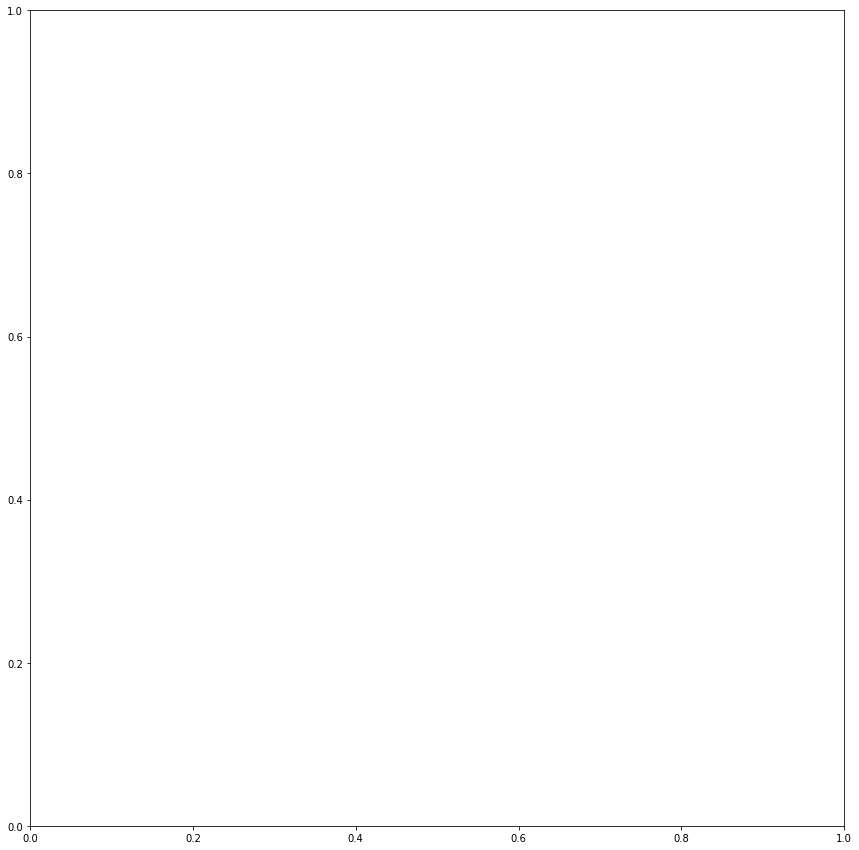

In [11]:
train_group = train_data.groupby('TRANSPORT_TRACE')
group = train_group.get_group('LTKLJ-DEHAM-HONG KONG_HONG KONG')
Order = pd.DataFrame()
Order[['loadingOrder']] = group[['loadingOrder']]
Order.drop_duplicates(subset = ['loadingOrder'], keep = 'first', inplace = True)
Order = np.array(Order['loadingOrder'])
print(Order)
example = group.groupby('loadingOrder').get_group(Order[0])
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import geopandas as gp
from shapely.geometry import Point
lng = np.array(example['longitude'])
lat= np.array(example['latitude'])
print(len(lng))
#pts = gp.GeoSeries([Point(x, y) for x, y in zip(lng, lat)])
#pts.plot()
# 世界地图

# ['CNSHK', 'GRPIR', 'ITSPE', 'ITGOA'] 5.87038 84.500385 44.40565 8.946256
# ['CNYTN', 'HKHKG', 'NZAKL', 'AUBNE'] 11.834633 128.983183 -27.383267 153.164629
# ['CNSHK', 'CNNSA', 'MYTPP', 'SGSIN', 'BJCOO', 'CIABJ'] -5.7323 84.065217 5.305333 -4.0041199999999995
# ['CNNSA', 'MYTPP', 'SGSIN', 'ZACPT', 'CGPNR', 'GALBV', 'CMKBI'] -22.893365 14.49949 2.939002 9.906216
fig, ax = plt.subplots(figsize=(30, 15))
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world.plot(ax = ax)
print(lng[0], lat[0])
print(lng[-1], lat[-1])
#cities.plot(ax=ax, marker='o', color='red', markersize=5)
plt.scatter(lng[:],lat[:],marker='x',color='g',s=20)#运单轨迹
plt.scatter(14.49949, -22.893365, marker='*',color='g',label='start', s=100)#起点
plt.scatter(9.906216, 2.939002, marker='*',color='b',label='start', s=100)#起点
plt.scatter(lng[0],lat[0],marker='*',color='b',label='start',s=50)#起点
plt.scatter(lng[len(lng)-1],lat[len(lat)-1],marker='*',color='r',label='end',s=50)#终点
plt.show()

In [16]:
group.groupby('loadingOrder').get_group(Order[4])

,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,diff_time,diff_lat,diff_lon
29294183,UK693787941550,2020-03-05 21:39:00+00:00,121.12500,25.562500,V1577807785,1.0,400,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,0.000000,0.000000,0.0000
29294184,UK693787941550,2020-03-21 09:30:04+00:00,-171.87500,48.343750,V1577807785,32.0,9390,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,22311.066667,22.781250,-293.0000
29294185,UK693787941550,2020-03-23 07:44:34+00:00,-151.75000,44.875000,V1577807785,36.0,11210,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2774.500000,-3.468750,20.1250
29294186,UK693787941550,2020-03-23 08:39:46+00:00,-151.37500,44.750000,V1577807785,36.0,11270,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,55.200000,-0.125000,0.3750
29294187,UK693787941550,2020-04-22 01:10:58+00:00,-76.81250,17.984375,S6489662802,0.0,13000,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,42751.200000,-26.765625,74.5625
...,...,...,...,...,...,...,...,...,...,...,...
29295422,UK693787941550,2020-04-26 15:30:59+00:00,-61.53125,10.648438,S6489662802,8.0,5820,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,4.033333,0.000000,0.0000
29295423,UK693787941550,2020-04-26 15:34:48+00:00,-61.53125,10.648438,S6489662802,5.0,8350,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,3.816667,0.000000,0.0000
29295424,UK693787941550,2020-04-26 15:39:08+00:00,-61.53125,10.648438,S6489662802,3.0,5990,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,4.333333,0.000000,0.0000
29295425,UK693787941550,2020-04-26 15:43:08+00:00,-61.53125,10.648438,S6489662802,1.0,33110,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,4.000000,0.000000,0.0000


In [159]:
test_data['diff_time'] = test_data.groupby('loadingOrder')['timestamp'].diff(1).dt.total_seconds() / 60
test_data['diff_lat'] = test_data.groupby('loadingOrder')['latitude'].diff(1)
test_data['diff_lon'] = test_data.groupby('loadingOrder')['longitude'].diff(1)
test_data.fillna(0, inplace = True)
test_data[test_data['diff_time'] > 2000]

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp,diff_time,diff_lat,diff_lon
17827,HJ790123244299,2019-06-20 20:22:08+00:00,105.741667,3.906667,0.0,-1.0,JCMFTA,M1075899155,2019-06-17 13:24:00,CNYTN-MATNG,2019-06-20T20:22:08.000Z,2281.000000,-6.481666,-5.141666
21755,JH101436980795,2020-03-18 22:25:58+00:00,112.110460,14.356855,23.0,20500.0,OIEQNT,G1659327376,2020-03-17 03:57:00,CNSHK-SGSIN,2020-03-18T22:25:58.000Z,2481.833333,-7.989583,-1.915813
21822,JK944314963943,2019-08-25 13:46:28+00:00,107.558565,6.629025,0.0,-1.0,RWHZVZ,U9574815950,2019-08-23 08:36:00,CNYTN-MTMLA,2019-08-25T13:46:28.000Z,2243.000000,-11.967172,-5.280282
26955,LS475777921461,2019-06-19 19:53:48+00:00,109.721667,9.883333,0.0,-1.0,RWHZVZ,G9393704581,2019-06-17 08:56:00,CNSHK-ZADUR,2019-06-19T19:53:48.000Z,2001.000000,-6.935000,-3.445000
28108,MU690927219794,2019-04-02 13:40:48+00:00,123.619297,18.074185,0.0,-1.0,UQCRKD,M3288411589,2019-04-01 03:44:00,CNSHK-CLVAP,2019-04-02T13:40:48.000Z,2036.000000,-3.802782,8.599830
53837,YV342585220795,2019-04-09 13:19:28+00:00,122.522538,29.730088,11.0,27670.0,OIEQNT,D7828192902,2019-04-01 18:32:00,CNYTN-MXZLO,2019-04-09T13:19:28.000Z,2160.166667,-0.829882,0.331981
53856,YV342585220795,2019-04-13 02:54:48+00:00,137.412612,39.816323,32.0,5680.0,OIEQNT,D7828192902,2019-04-01 18:32:00,CNYTN-MXZLO,2019-04-13T02:54:48.000Z,2419.500000,8.361436,12.015105


In [160]:
test_data[abs(test_data['diff_lon']) + abs(test_data['diff_lat']) > 20]

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp,diff_time,diff_lat,diff_lon
20112,IK608316304754,2019-09-11 17:17:38+00:00,-179.197240,47.813207,35.0,9130.0,OYSCFP,Z7715601678,2019-08-31 21:57:00,CNYTN-PAONX,2019-09-11T17:17:38.000Z,692.5,0.035985,-354.547798
53856,YV342585220795,2019-04-13 02:54:48+00:00,137.412612,39.816323,32.0,5680.0,OIEQNT,D7828192902,2019-04-01 18:32:00,CNYTN-MXZLO,2019-04-13T02:54:48.000Z,2419.5,8.361436,12.015105


In [169]:
test_data.groupby('TRANSPORT_TRACE').get_group('CNSHK-SGSIN-MTMLA-DZALG')

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp,diff_time,diff_lat,diff_lon
25454,LM121664928482,2020-06-02 02:09:33+00:00,14.534182,35.821510,0.0,30270.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T02:09:33.000Z,0.000000,0.000000,0.000000
25455,LM121664928482,2020-06-02 02:09:36+00:00,14.534182,35.821510,0.0,30300.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T02:09:36.000Z,0.050000,0.000000,0.000000
25456,LM121664928482,2020-06-02 02:15:33+00:00,14.534182,35.821505,0.0,30190.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T02:15:33.000Z,5.950000,-0.000005,0.000000
25457,LM121664928482,2020-06-02 02:21:33+00:00,14.534195,35.821523,0.0,30450.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T02:21:33.000Z,6.000000,0.000018,0.000013
25458,LM121664928482,2020-06-02 02:24:34+00:00,14.534175,35.821523,0.0,30450.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T02:24:34.000Z,3.016667,0.000000,-0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25774,LM121664928482,2020-06-02 22:48:29+00:00,11.958382,37.062257,26.0,30200.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T22:48:29.000Z,8.133333,0.017529,-0.034771
25775,LM121664928482,2020-06-02 22:55:27+00:00,11.930242,37.076688,25.0,30400.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T22:55:27.000Z,6.966667,0.014431,-0.028140
25776,LM121664928482,2020-06-02 23:28:03+00:00,11.796572,37.147553,26.0,30300.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T23:28:03.000Z,32.600000,0.070865,-0.133670
25777,LM121664928482,2020-06-02 23:43:51+00:00,11.730447,37.182505,27.0,30400.0,RWHZVZ,A2177695011,2020-06-02 02:09:33,CNSHK-SGSIN-MTMLA-DZALG,2020-06-02T23:43:51.000Z,15.800000,0.034952,-0.066125


In [ ]:
test_label = np.array([346.51371528, 565.09092391, 562.05565   , 875.78627778,
       577.34510851, 707.54059343, 574.64097222, 587.25064815,
       854.09850694, 558.19251068, 486.17434524,   0.        ,
       577.34510851, 332.24729167, 285.75469697, 677.7309375 ,
       547.81715278, 606.05962963,   0.        , 713.67077991,
       590.32833333, 565.16898727,   0.        , 590.32833333,
       565.63923032, 565.63923032, 679.26095486, 679.26095486,
       589.26789683, 679.26095486, 590.32833333, 577.34510851,
       590.07095238, 588.98914683,   0.        , 577.34510851,
       590.32833333, 588.9010119 , 590.32833333, 679.26095486,
       679.26095486, 590.32833333, 565.96857639, 565.96857639,
       549.49165741, 590.32833333, 589.11275794, 588.9010119 ,
       577.34510851, 590.07095238, 529.21761111, 529.21761111,
       590.32833333, 398.01960784,   0.        , 100.77880719,
       577.34510851,  92.32464659, 577.34510851, 148.33700539,
       577.34510851,  19.74736806, 577.34510851, 577.34510851,
       101.        ,   0.        , 843.17305556,  85.7640424 ,
       148.33700539, 148.33700539,  87.9519494 ,  87.74450231,
       458.48430556, 129.04661537,  92.32464659,  89.04403747,
       599.21581944,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [170]:
gc.collect()

1124